In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    biobank_data_no_HLA_alleles, biobank_index, med_code_mapping = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 285 features.
UK BioBank Data Loaded.
Size: 502536 rows x 285 columns
Elapsed time: 49.6279 seconds


Mapping Medical Codes:   0%|          | 0/270 [00:00<?, ? feature/s]

In [5]:
clinical_mono_label = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
hiv_label = "hiv/aids"
hepatitis_label = "infective/viral hepatitis"
measles_label = "measles / morbillivirus"

biobank_data["clinical_mononucleosis"] = get_illness_value(biobank_data, illness=clinical_mono_label,
                                                           base_feature="illness_code")

biobank_data["HIV/AIDS"] = get_illness_value(biobank_data, illness=hiv_label, base_feature="illness_code")
biobank_data["hepatitis"] = get_illness_value(biobank_data, illness=hepatitis_label, base_feature="illness_code")
biobank_data["measles"] = get_illness_value(biobank_data, illness=measles_label, base_feature="illness_code")

 # Basic Summary stats

In [6]:
cancer_data = biobank_data.loc[~biobank_data["cancer_code"].isna()].copy(deep=True)

In [7]:
variables_of_interest = ["sex", "cancer_code"]

grouping_df = cancer_data[variables_of_interest].copy(deep=True)
grouping_df["total"] = grouping_df["sex"] != "nothing"
grouping_df["female"] = grouping_df["sex"] == "Female"
grouping_df["male"] = grouping_df["sex"] == "Male"
grouping_df = grouping_df.groupby("cancer_code").sum().reset_index()

grouping_df = grouping_df.loc[ ~grouping_df["cancer_code"].isin(constants.SEX_SPECIFIC_CANCERS)]
grouping_df = grouping_df.query("total > 5").sort_values("total", ascending=False)
most_common_cancers = grouping_df["cancer_code"]

grouping_df["male_fraction"] = grouping_df["male"] / grouping_df["total"]
grouping_df["female_fraction"] = grouping_df["female"] / grouping_df["total"]
grouping_df

,cancer_code,total,female,male,male_fraction,female_fraction
4,basal cell carcinoma,4064,2402,1662,0.408957,0.591043
34,malignant melanoma,3477,2072,1405,0.404084,0.595916
14,colon cancer/sigmoid cancer,1472,624,848,0.576087,0.423913
64,skin cancer,1354,680,674,0.497784,0.502216
5,bladder cancer,1049,278,771,0.734986,0.265014
...,...,...,...,...,...,...
3,appendix cancer,13,8,5,0.384615,0.615385
71,thymus cancer / malignant thymoma,10,5,5,0.500000,0.500000
55,peripheral nerve/autonomic nerve cancer,10,4,6,0.600000,0.400000
37,metastatic cancer (unknown primary),9,6,3,0.333333,0.666667


# Example Plot

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


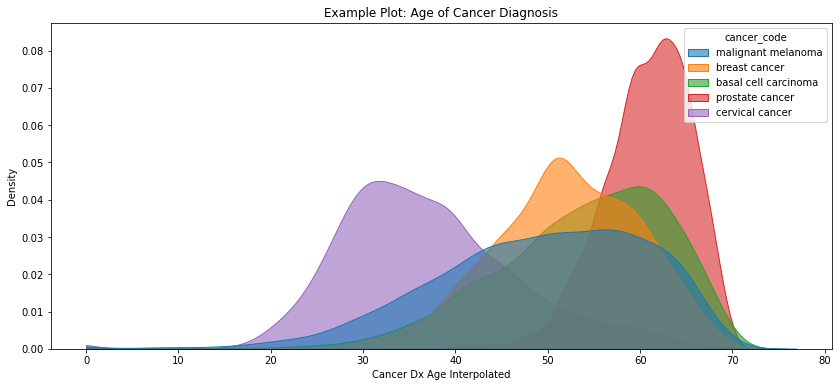

In [8]:
cancer_codes, counts = np.unique(cancer_data["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_data = cancer_data.loc[cancer_data["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_data, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False, bw=.2, alpha=.6, clip=[0, None])
ax.set_title("Example Plot: Age of Cancer Diagnosis")
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_dx_age.png"), facecolor="#fffffe")

# Sex Distributions

/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_31835/187666653.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


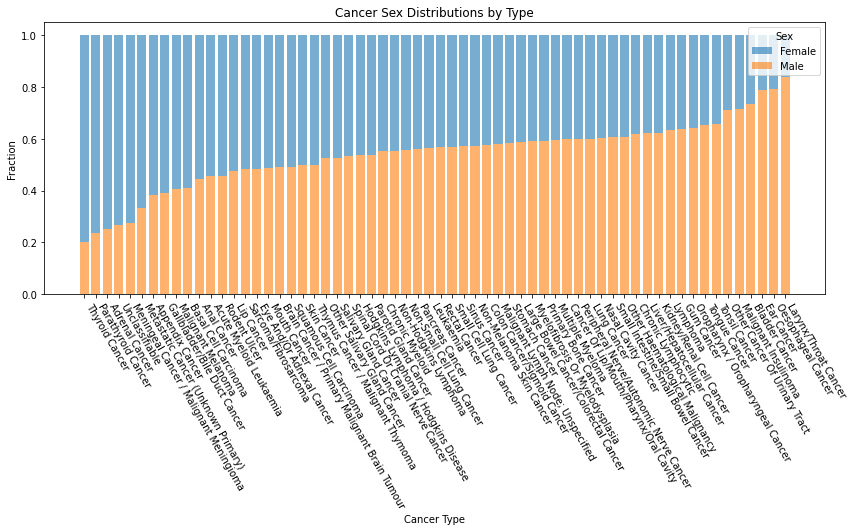

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("male_fraction")
ax.bar(data=data, x="cancer_code", height="female_fraction",
       bottom="male_fraction", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male_fraction", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Fraction")
ax.legend(title="Sex")
ax.set_title("Cancer Sex Distributions by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

/var/folders/vy/ng8z35ts71z736pdwsgxy_300000gn/T/ipykernel_31835/3407320492.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


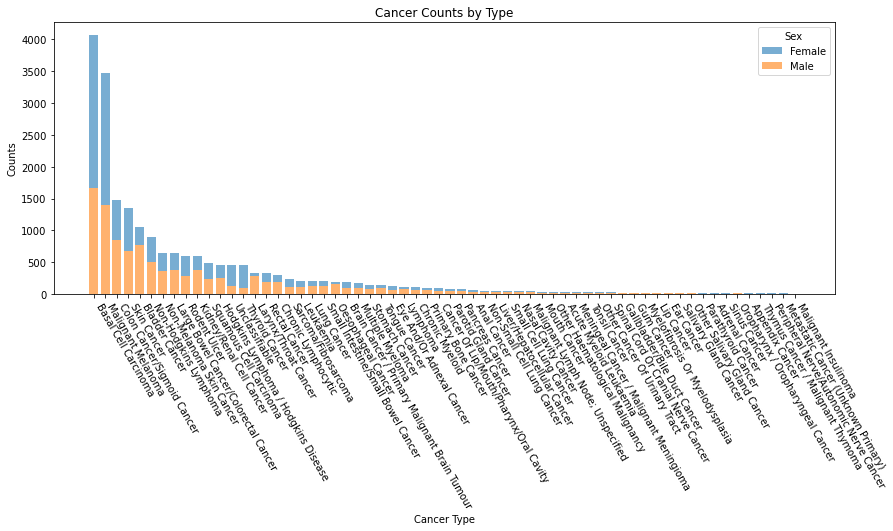

In [10]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("total", ascending=False)

ax.bar(data=data, x="cancer_code", height="female", bottom="male", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Counts")
ax.legend(title="Sex")
ax.set_title("Cancer Counts by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

Text(0.5, 1.0, 'Cancer Age Distributions')

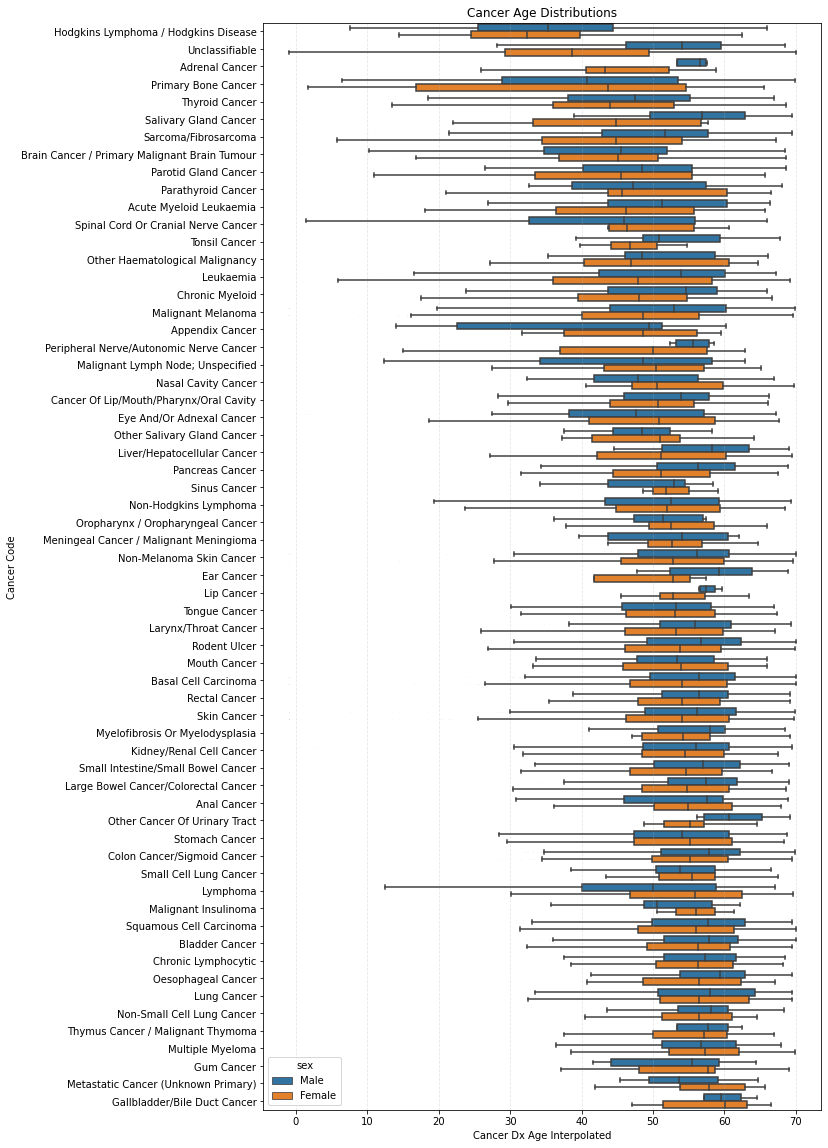

In [11]:
fig, ax = plt.subplots(figsize=(10, 20))
data = cancer_data.loc[cancer_data["cancer_code"].isin(most_common_cancers)].copy(deep=True)

sort_df = data.query("sex == 'Female'")[["cancer_dx_age_interpolated", "cancer_code"]
                                     ].groupby("cancer_code").median().reset_index()
sort_dict = dict(zip(sort_df["cancer_code"], sort_df["cancer_dx_age_interpolated"]))
sort_function = lambda key: sort_dict[key]
sort_function = np.vectorize(sort_function)

data["sort"] = data["cancer_code"].apply(sort_function)
data = data.sort_values("sort")

y, x = "cancer_code", "cancer_dx_age_interpolated"
sns.boxplot(data=data, x=x, y=y, hue="sex", ax=ax, orient="h", fliersize=.01)
ax.xaxis.grid(True, alpha=.3, linestyle="--", zorder=-10)

ax.set_yticklabels([t._text.title() for t in ax.get_yticklabels()]);
add_plt_labels(ax, x=x, y=y)
ax.set_title("Cancer Age Distributions")

In [12]:
from utilities import *

# Dx Age Distributions

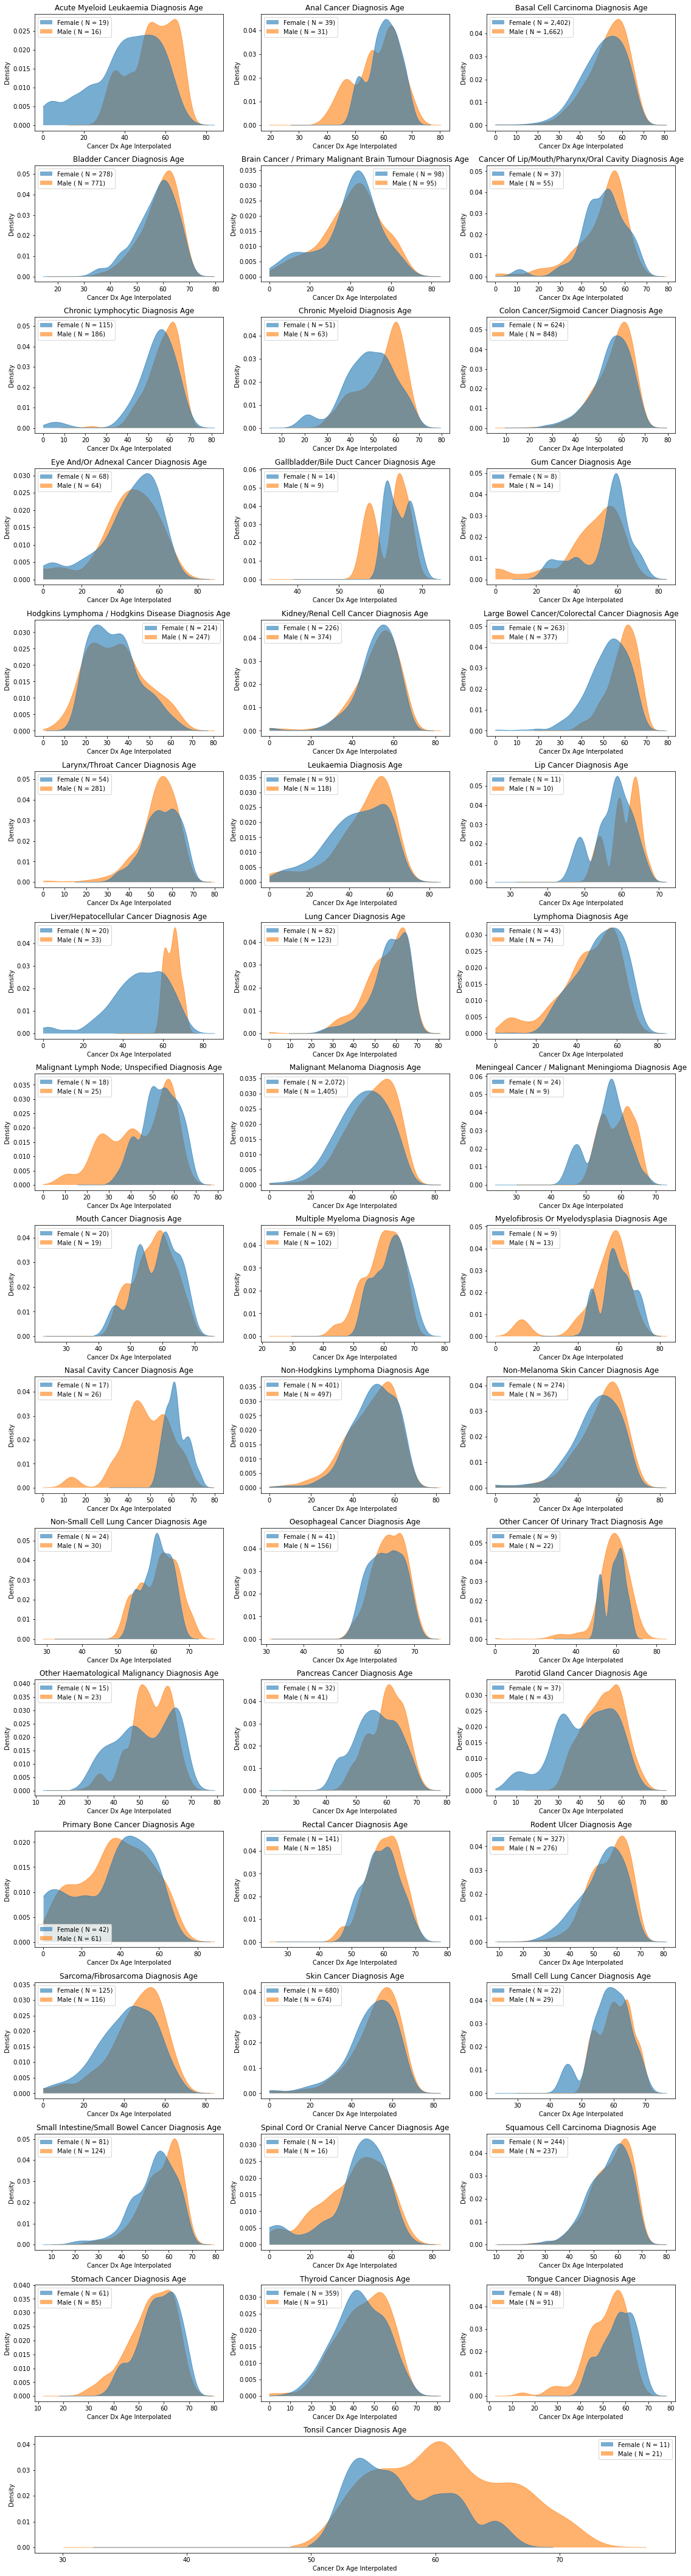

In [13]:
x, y, hue = "cancer_dx_age_interpolated", "density", "sex"

cancer_types = exclude(sorted(cancer_data["cancer_code"].unique()), constants.SEX_SPECIFIC_CANCERS)

plot_cancer_types = []
for cancer_type in cancer_types:
    data = cancer_data.query(f"cancer_code == '{cancer_type}'")
    counts = np.unique(data[hue], return_counts=True)[1]

    if len(data) > 20 and len(counts) > 1:
        plot_cancer_types.append(cancer_type)

fig, axes = create_subplot(len(plot_cancer_types), ncols=3, height_per=3)

for ax, cancer_code in zip(axes, plot_cancer_types):
    data = cancer_data.query(f"cancer_code == '{cancer_code}'")
    kde_plot(data=data, x=x, hue=hue, ax=ax, bw=.3, clip=(0, None))
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_code.title()} Diagnosis Age")

# Viral Specific Exploration

In [14]:
viral_cancer_types = [
    'hodgkins lymphoma / hodgkins disease', 'larynx/throat cancer', 'stomach cancer',
    'anal cancer', 'liver/hepatocellular cancer',
    'cancer of lip/mouth/pharynx/oral cavity',
    'nasal cavity cancer', 'kaposis sarcoma', "cervical cancer"
]

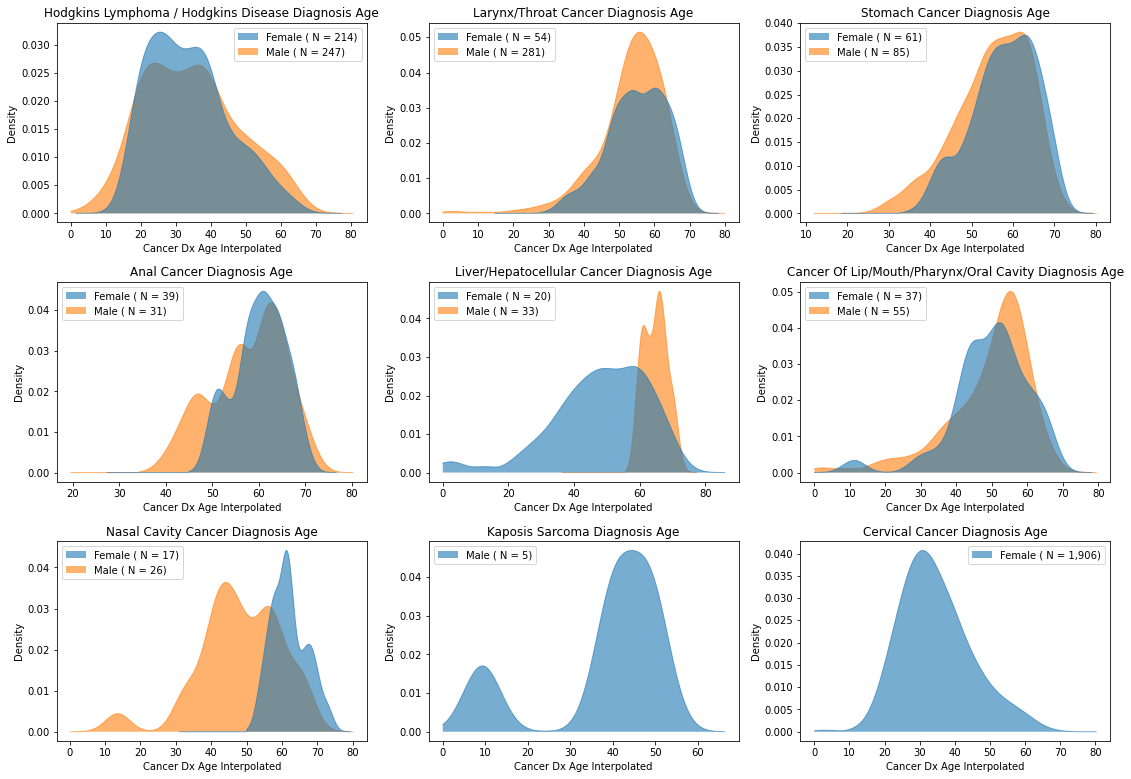

In [15]:
x, y, hue = "cancer_dx_age_interpolated", "density", "sex"


fig, axes = create_subplot(len(viral_cancer_types), ncols=3, height_per=3)

for ax, cancer_code in zip(axes, viral_cancer_types):
    data = cancer_data.query(f"cancer_code == '{cancer_code}'")
    kde_plot(data=data, x=x, hue=hue, ax=ax, bw=.3, clip=[0, None])
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_code.title()} Diagnosis Age")

In [16]:
from analysis import *

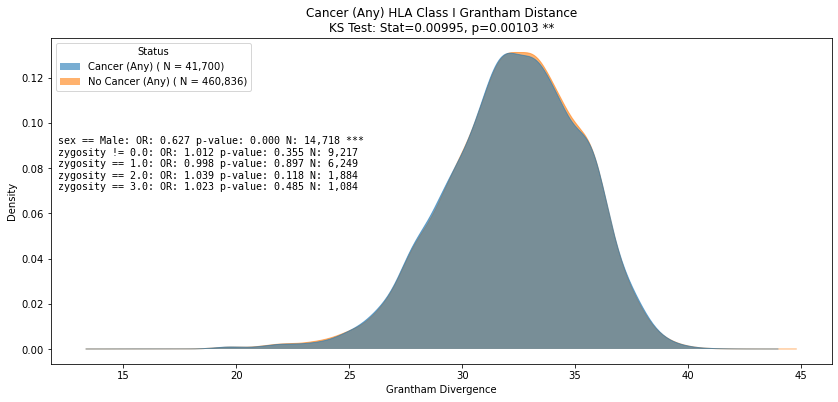

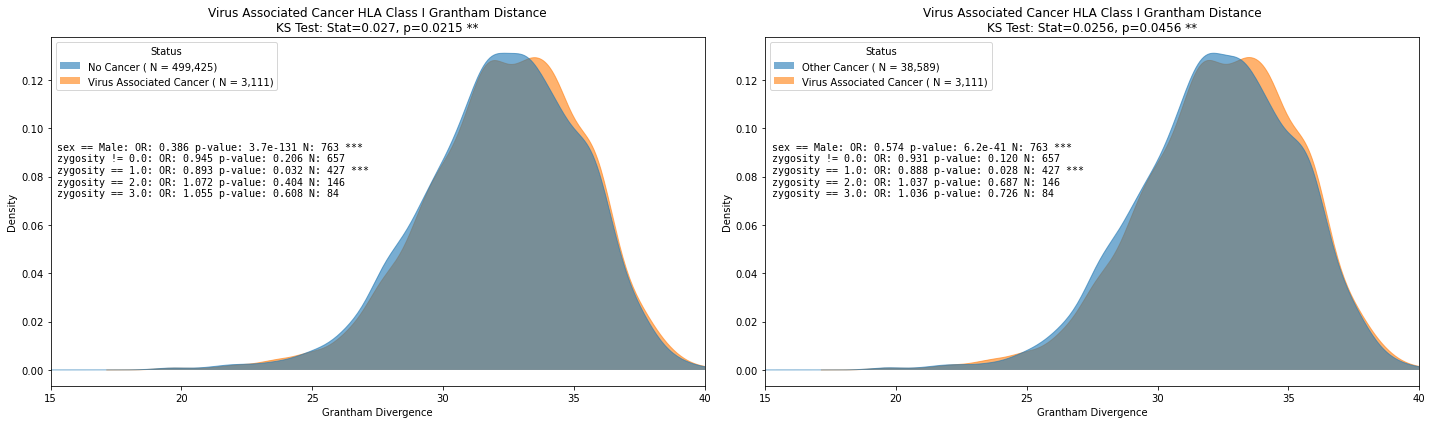

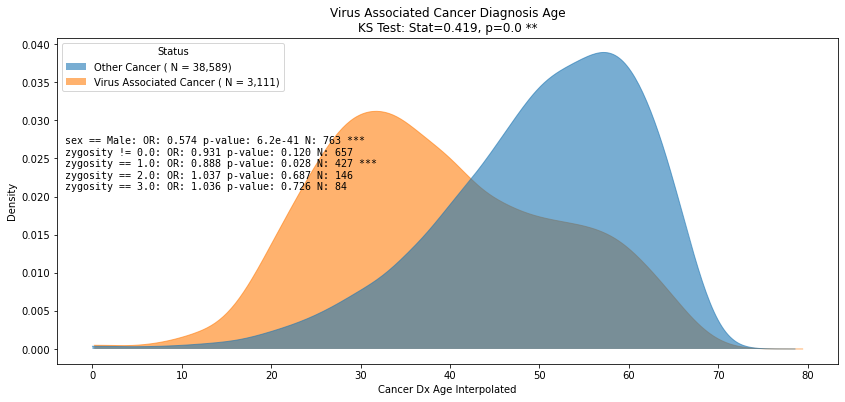

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
variable_OR_plot(biobank_data, "cancer (any)", ~biobank_data["cancer_code"].isna(),
                 OR_variable=["sex", "zygosity"], ax=ax, title=" HLA Class I Grantham Distance")
fig.savefig(f"cancer_EDA_plots/HLA_grantham_distance_all_cancers.png")

fig, (a0, a1) = plt.subplots(figsize=(20, 6), ncols=2)
variable_OR_plot(biobank_data, "virus associated cancer", biobank_data["cancer_code"].isin(viral_cancer_types),
                 OR_variable=["sex", "zygosity"], ax=a0, no_illness_label="no cancer",
                 title=" HLA Class I Grantham Distance")
a0.set_xlim(15, 40)
variable_OR_plot(cancer_data, "virus associated cancer", cancer_data["cancer_code"].isin(viral_cancer_types),
                 OR_variable=["sex", "zygosity"], ax=a1, no_illness_label="other cancer",
                title=" HLA Class I Grantham Distance")
a1.set_xlim(15, 40)
fig.tight_layout()
fig.savefig(f"cancer_EDA_plots/HLA_grantham_distance_viral_associated.png")

fig, ax = plt.subplots(figsize=(14, 6))
variable_OR_plot(cancer_data, "virus associated cancer", cancer_data["cancer_code"].isin(viral_cancer_types),
                 OR_variable=["sex", "zygosity"], ax=ax, x="cancer_dx_age_interpolated",
                 no_illness_label="other cancer", clip=(0, None), title=" Diagnosis Age")
fig.savefig(f"cancer_EDA_plots/cancer_dx_age_virus_associated.png")

In [18]:
from tqdm.notebook import tqdm

In [19]:
from statannotations.Annotator import Annotator

In [20]:
def HLA_loci_gd_plot(illness: str, feature: str, data: pd.DataFrame, ax = None):
    """"""
    HLA_loci_gds = ["A_grantham_distance", "B_grantham_distance", "C_grantham_distance"]
    melt_data = data[HLA_loci_gds].copy(deep=True)
    illness_index = get_illness_value(data, illness, feature)

    hues = [f"{titleize(illness)} (N = {np.count_nonzero(illness_index):,})",
            f"No {titleize(illness)} (N = {np.count_nonzero(~illness_index):,})"]
    
    illness_values = np.array(hues[-1:] * len(data))
    illness_values[illness_index] = hues[0]
    melt_data["Illness"] = illness_values
    melt_data = melt_data.melt(id_vars=["Illness"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = None
    params = dict(data=melt_data, x="variable", y="value", hue="Illness",
                  hue_order=hues)

    sns.boxplot(**params, palette="tab20", ax=ax)
    ax.set_title(f"{titleize(illness)}")
    ax.set_xlabel("HLA Locus")
    ax.set_ylabel("Grantham Distance")
    ax.set_xticklabels(["A", "B", "C"])
    ax.legend(prop={'size': 8})

    pairs = [[(loci, v) for v in np.unique(illness_values)] for loci in HLA_loci_gds]

    annotator = Annotator(ax, pairs, **params)
    annotator.configure(test='Mann-Whitney', text_format='simple', verbose=-1)
    annotator.apply_and_annotate()
    
    return fig, ax

''

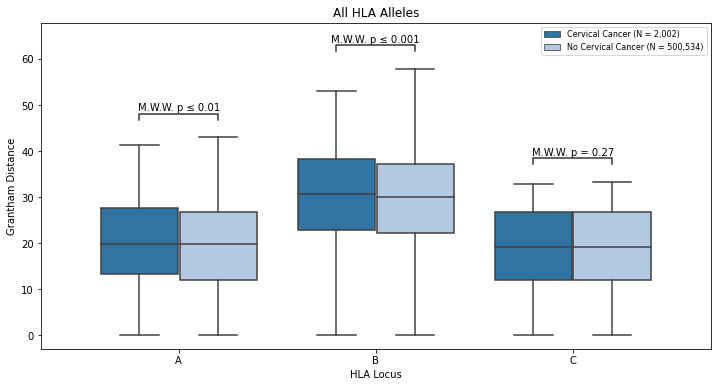

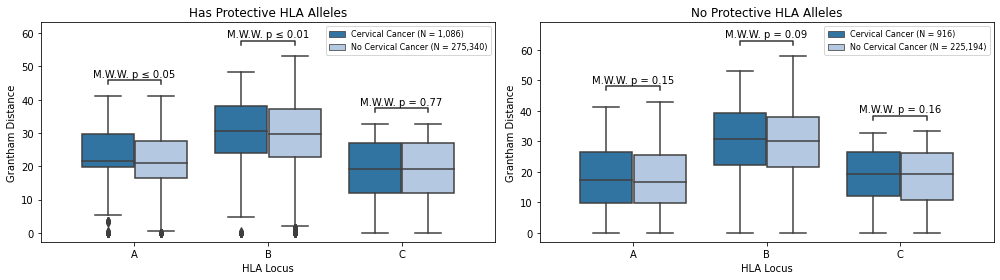

In [23]:
illness = "cervical cancer"
feature = "cancer_code"

fig, ax = HLA_loci_gd_plot(illness, feature, biobank_data)
ax.set_title("All HLA Alleles")

HLA_allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]
cervical_protective_alleles = ["A*02:01", "C*04:01"]
has_protective_allele = biobank_data[HLA_allele_columns].isin(cervical_protective_alleles).any(axis=1)


fig, (a0, a1) = plt.subplots(figsize=(14, 4), ncols=2)
HLA_loci_gd_plot(illness, feature, biobank_data.loc[has_protective_allele], ax=a0)
a0.set_title("Has Protective HLA Alleles")


HLA_loci_gd_plot(illness, feature, biobank_data.loc[~has_protective_allele], ax=a1)
a1.set_title("No Protective HLA Alleles")
fig.tight_layout()

# fig, ax = HLA_loci_gd_plot(illness, feature, biobank_data.loc[biobank_data["zygosity"] == 0])
# ax.set_title("Full heterozygosity HLA Alleles")

# fig, ax = HLA_loci_gd_plot(illness, feature, biobank_data.loc[biobank_data["zygosity"] != 0])
# ax.set_title("Reduced heterozygosity HLA Alleles")
;

In [24]:
class_I_allele_map = gd.HLAAlleleSequenceMapping(gd.HLA_CLASS_I_ALLELE_AMINO_ACID_SEQUENCES_ABS_PATH)
grantham_distance = gd.GranthamDistance(gd.GRANTHAM_DISTANCE_MATRIX_PATH)
all_alleles = biobank_data[constants.HLA_ALLELE_COLUMNS].values.ravel()
all_alleles = sorted(np.unique(all_alleles[~pd.isnull(all_alleles)]))
all_alleles = exclude(all_alleles, cervical_protective_alleles)

In [25]:
import itertools


# grantham_distance.sequence_pair_distance(*pair)
gds, labels, loci = [], [], []
for locus in ["A", "B", "C"]:
    all_sequences = class_I_allele_map._map([a for a in all_alleles if a.startswith(locus)])
    protective_sequences = class_I_allele_map._map([a for a in cervical_protective_alleles if a.startswith(locus)])
    
    all_gds = [grantham_distance.sequence_pair_distance(*pair) for pair in itertools.combinations(all_sequences, 2)]
    protective_gds = [grantham_distance.sequence_pair_distance(p_seq, a_seq)
                       for p_seq in protective_sequences for a_seq in all_sequences]
    
    loci += [locus] * (len(all_gds) + len(protective_gds))
    labels += ["All Other Sequences"] * len(all_gds) + ["Protective Sequences"] * len(protective_gds)
    gds += all_gds + protective_gds

df = pd.DataFrame({"Grantham Distance": gds, "label": labels, "loci": loci})

Text(0.5, 1.0, 'Comparison of Grantham Distances between Protective Alleles vs Others')

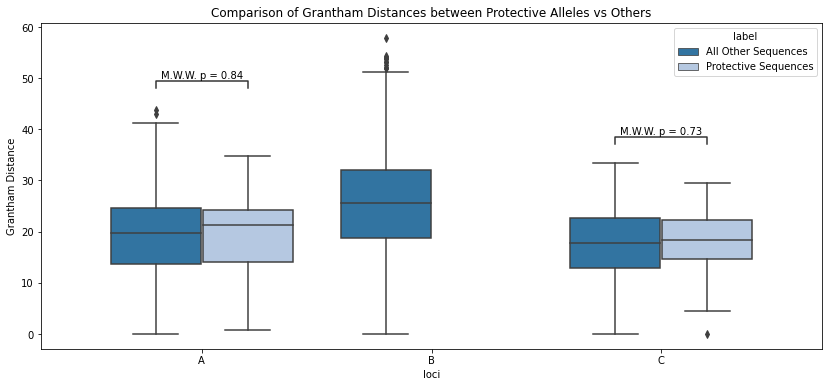

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=df, x="loci", y="Grantham Distance", hue="label", palette="tab20")
pairs = [(('A', "All Other Sequences"), ("A", "Protective Sequences")),
         (('C', "All Other Sequences"), ("C", "Protective Sequences"))]
annotator = Annotator(ax, pairs, data=df, x="loci", y="Grantham Distance", hue="label")
annotator.configure(test='Mann-Whitney', text_format='simple', verbose=-1)
annotator.apply_and_annotate()
ax.set_title("Comparison of Grantham Distances between Protective Alleles vs Others")

  0%|          | 0/9 [00:00<?, ?it/s]

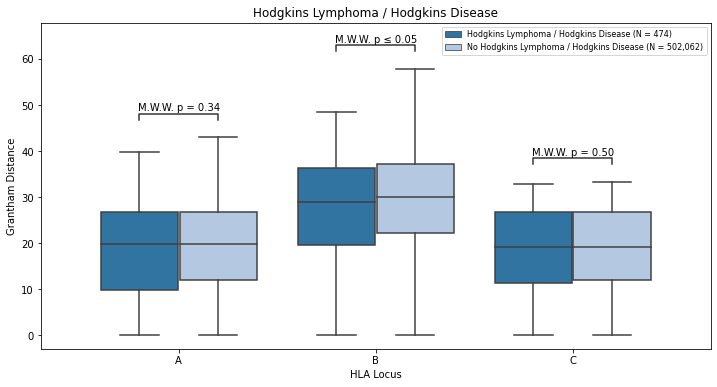

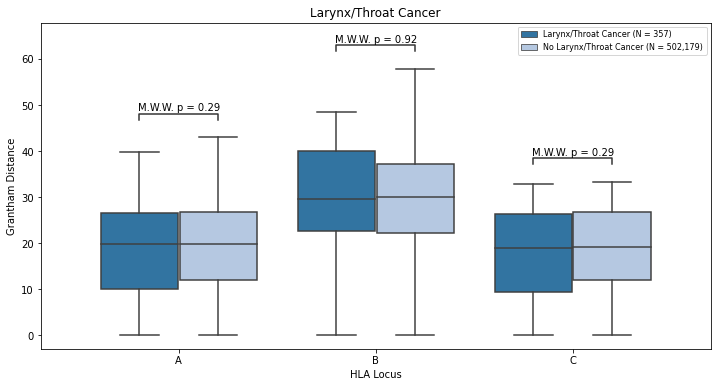

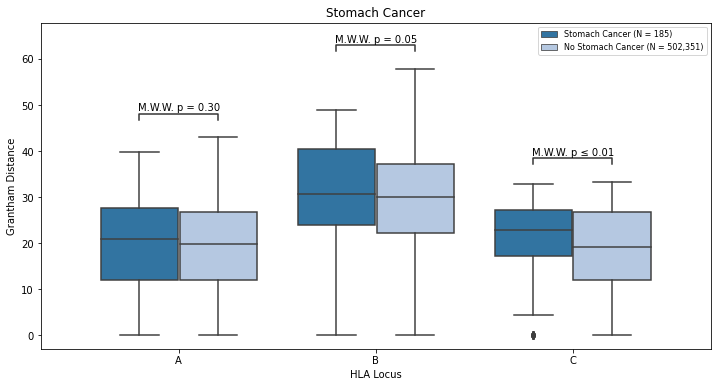

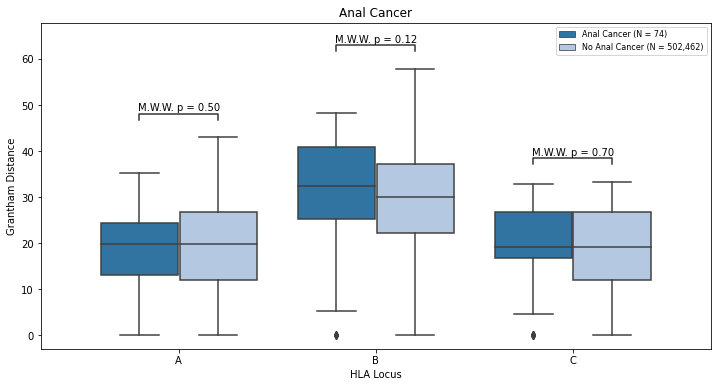

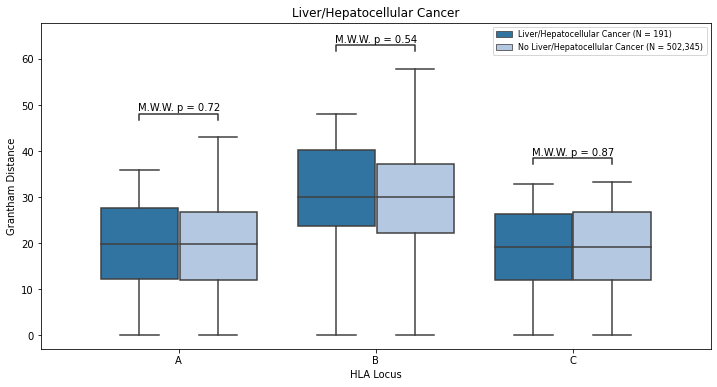

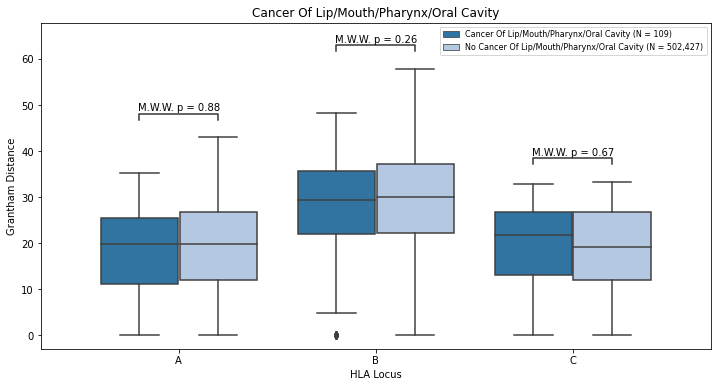

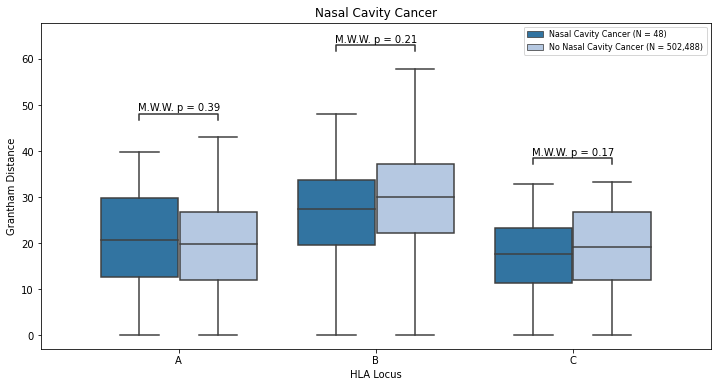

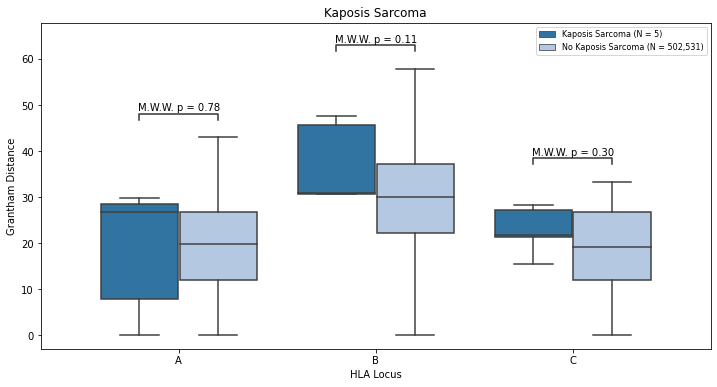

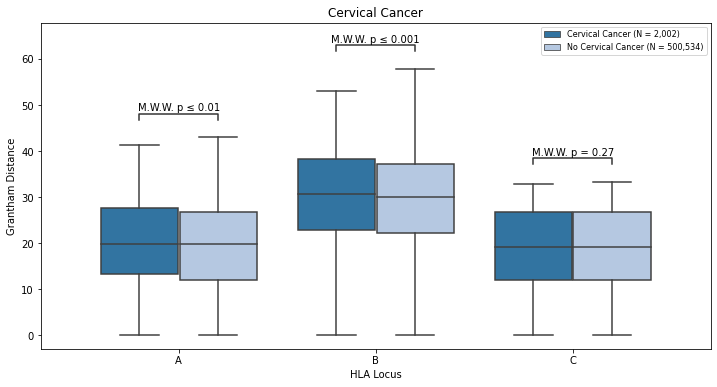

In [27]:
for illness in tqdm(viral_cancer_types):
    HLA_loci_gd_plot(illness, "cancer_code", biobank_data)

  0%|          | 0/9 [00:00<?, ?it/s]

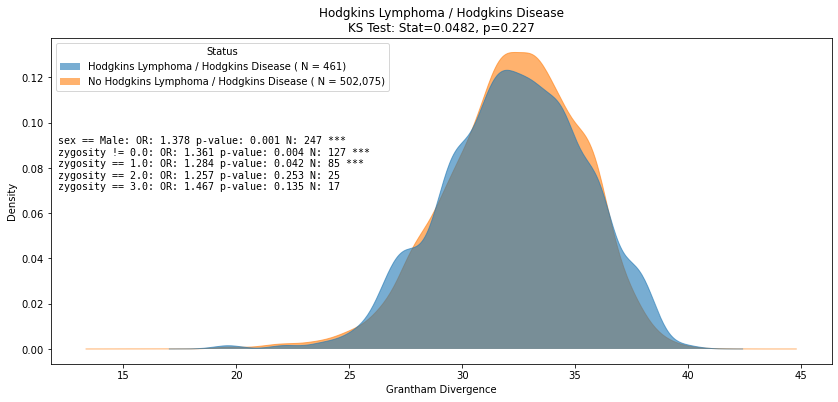

In [28]:
x = "grantham_divergence"
OR_variables = ["sex", "zygosity"]

for cancer_code in tqdm(viral_cancer_types):
    fig, ax = variable_OR_plot(biobank_data, cancer_code, "cancer_code", x=x, OR_variable=OR_variables)
    save_name = cancer_code.replace(" ", "_").replace("/", "_")
    fig.savefig(f"cancer_EDA_plots/grantham_distance_plots/HLA_grantham_distance_{save_name}.png")
#     plt.close()
    break

  0%|          | 0/9 [00:00<?, ?it/s]

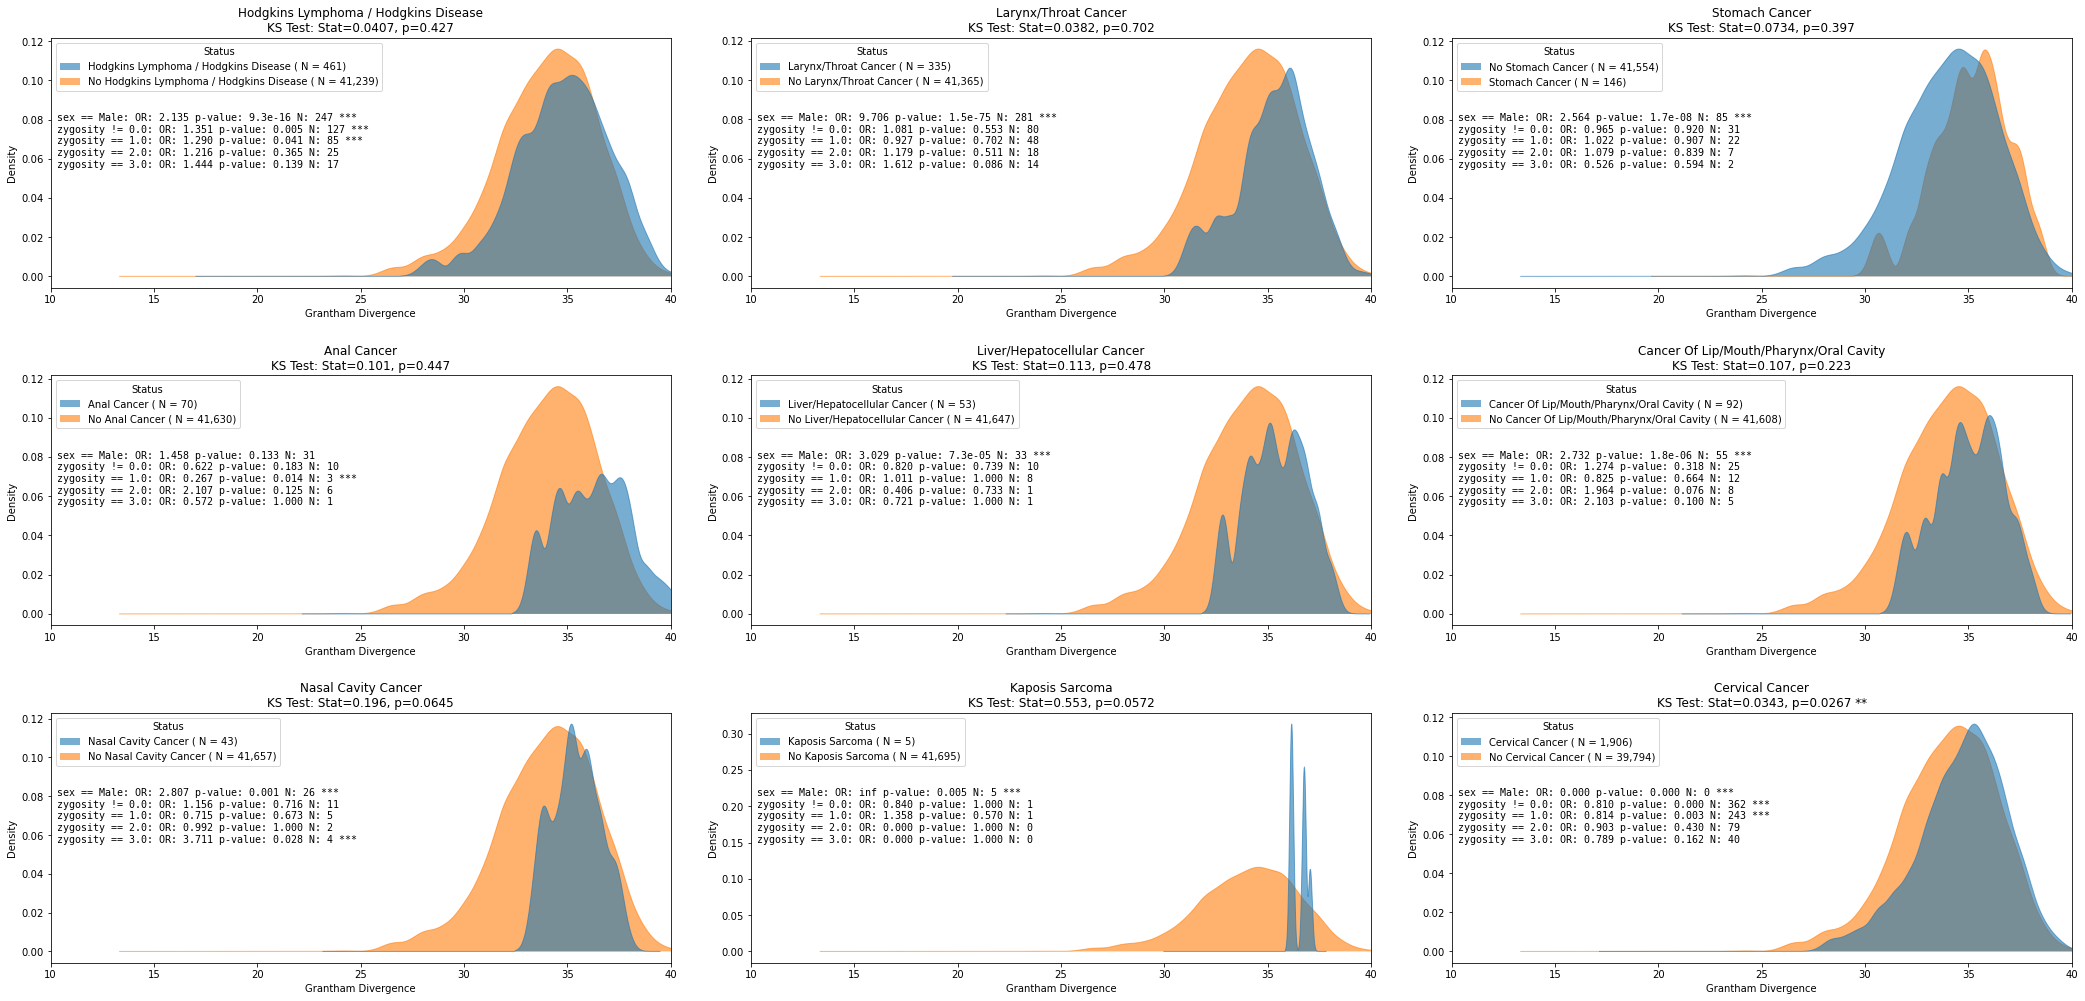

In [29]:
x = "grantham_divergence"
OR_variables = ["sex", "zygosity"]

fig, axes = create_subplot(len(viral_cancer_types), ncols=3, width=30,
                           height_per=4, wspace=.13, hspace=.35)
for ax, cancer_code in zip(axes, tqdm(viral_cancer_types)):
    variable_OR_plot(cancer_data, cancer_code, "cancer_code", x=x, OR_variable=OR_variables, ax=ax, clip=(0, None))
    ax.set_xlim(10, 40)

fig.savefig(f"cancer_EDA_plots/grantham_distance_plots/HLA_grantham_distance_virus_associated_all.png")

  0%|          | 0/9 [00:00<?, ?it/s]

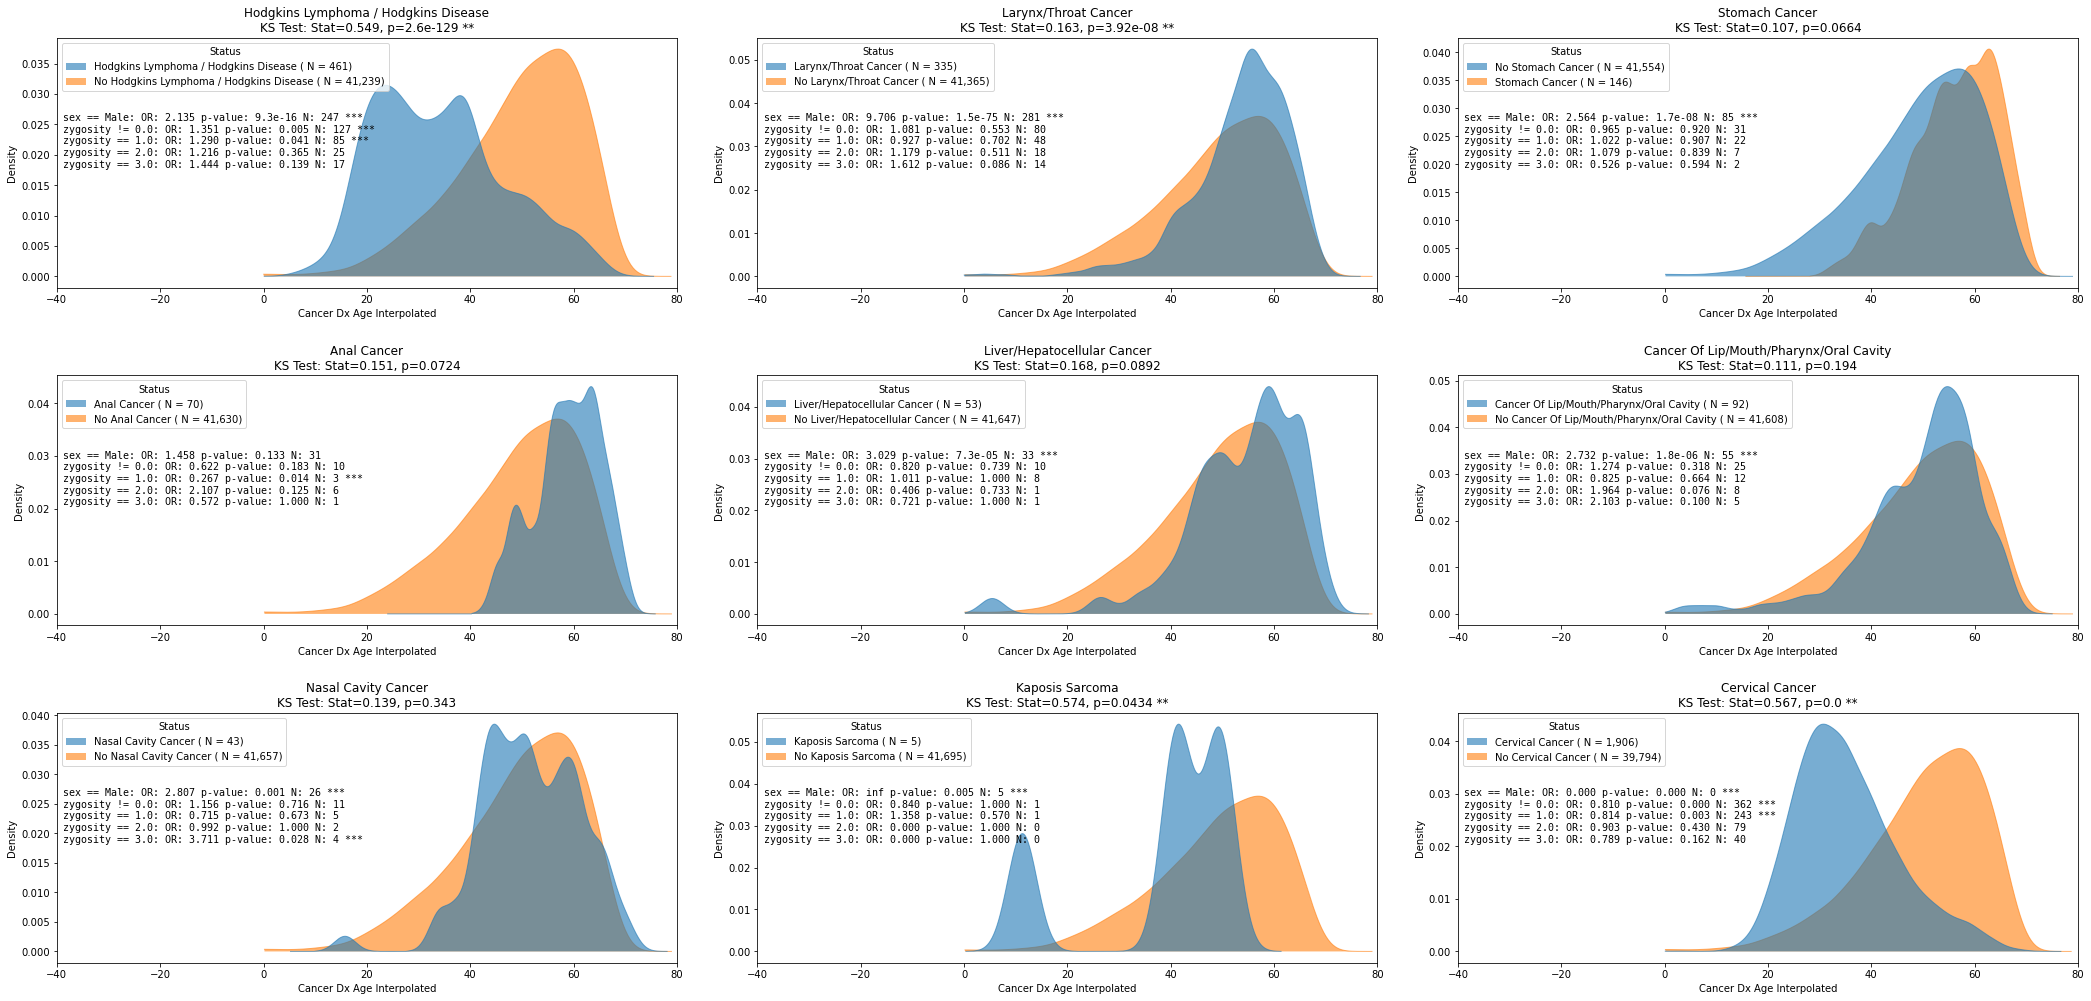

In [30]:
x = "cancer_dx_age_interpolated"

fig, axes = create_subplot(len(viral_cancer_types), ncols=3, width=30, height_per=4, wspace=.13, hspace=.35)
for ax, cancer_code in zip(axes, tqdm(viral_cancer_types)):
    variable_OR_plot(cancer_data, cancer_code, "cancer_code", x=x, OR_variable=OR_variables, ax=ax, clip=(0, None))
    ax.set_xlim(-40, 80)
    
fig.savefig(f"cancer_EDA_plots/cancer_dx_age_virus_associated_all.png")

In [31]:
def cancer_dx_age_groups(dx_age: float) -> str:
    """"""
#     if dx_age <= 20:
#         return "Ages 0-20"
    
    if dx_age <= 40:
        return "Ages 0-40"
    
#     if dx_age <= 60:
#         return "Ages 40-60"
    
    return "Ages > 40"

In [34]:
data = biobank_data

for illness in viral_cancer_types:
    print(illness.upper())
    illness_values = get_illness_value(data, illness, "cancer_code")
    text = ""
    for variable in ["sex", "zygosity", "clinical_mononucleosis", "HIV/AIDS", "hepatitis"]:
        line = variable_OR_test(illness=illness_values, variable=variable, CI=None, data=data)
        if not line.endswith("N: 0\n"):
            text += line
    print("\t" + text.replace('\n', '\n\t'))
    break

HODGKINS LYMPHOMA / HODGKINS DISEASE
	sex == Male: OR: 1.366 p-value: 0.001 N: 253 ***
	zygosity != 0.0: OR: 1.345 p-value: 0.005 N: 129 ***
	zygosity == 1.0: OR: 1.264 p-value: 0.052 N: 86
	zygosity == 2.0: OR: 1.225 p-value: 0.309 N: 25
	zygosity == 3.0: OR: 1.518 p-value: 0.104 N: 18
	clinical_mononucleosis == True: OR: 3.620 p-value: 0.107 N: 2
	HIV/AIDS == True: OR: 6.827 p-value: 0.010 N: 3 ***
	hepatitis == True: OR: 1.923 p-value: 0.280 N: 2
	


In [146]:
from analysis import *

In [35]:
disease = get_illness_value(biobank_data, cancer_code, "cancer_code")
text = variable_OR_test(disease, "zygosity", data=biobank_data, CI=None)
text = group_OR(disease, variable, groups, data=biobank_data, CI=None)

NameError: name 'groups' is not defined

In [36]:
import re

In [37]:
def parse_variable_OR_test(text: str):
    """"""
    info = []
    for line in text.split("\n")[:-1]:
        variable_label, rest = line.split(":", maxsplit=1)
        splits = re.split(': | ', rest)
        line_info = dict(zip(splits[1:-1:2], [float(s) for s in splits[2::2]]))
        line_info["variable"] = variable_label
        info.append(line_info)

    return pd.DataFrame(info)

In [38]:
def get_OR_df(data, illness, feature, variable):
    disease = get_illness_value(data, illness, feature)
    return parse_variable_OR_test(variable_OR_test(disease, variable, data=data, CI=None))

In [57]:
disease = get_illness_value(biobank_data, cancer_code, "cancer_code")
disease.sum()

474

In [61]:
(illness_dx_ages >= 0).sum()

474

In [53]:
variable = "zygosity"

cancer_code = "cervical cancer"
protective_alleles = ["A*02:01", "C*04:01"]
cancer_code = "hodgkins lymphoma / hodgkins disease"
protective_alleles = ["A*01:01", "B*44:02"]

_, illness_dx_ages = get_illness_value_dx_age(biobank_data, cancer_code, "cancer_code")
biobank_data["cancer_dx_age_groups"] = np.vectorize(cancer_dx_age_groups)(illness_dx_ages)

groups = ["sex", "cancer_dx_age_groups"] if cancer_code != "cervical cancer" else ["cancer_dx_age_groups"]

print("With Risk Alleles")
disease = get_illness_value(biobank_data, cancer_code, "cancer_code")
print(tab_shift(group_OR(disease, variable, groups, data=biobank_data, CI=None)))

print("Excluding Risk Alleles")
has_protective_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin(protective_alleles).any(axis=1)
data = biobank_data.loc[~has_protective_allele]
disease = get_illness_value(data, cancer_code, "cancer_code")
print(tab_shift(group_OR(disease, variable, groups, data=data, CI=None)))

print("Only Risk Alleles")
has_protective_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin(protective_alleles).any(axis=1)
data = biobank_data.loc[has_protective_allele]
disease = get_illness_value(data, cancer_code, "cancer_code")
print(tab_shift(group_OR(disease, variable, groups, data=data, CI=None)))

With Risk Alleles
    Female:
        Ages 0-40:
            zygosity != 0.0: OR: 1.482 p-value: 0.028 N: 48 ***
            zygosity == 1.0: OR: 1.377 p-value: 0.123 N: 32
            zygosity == 2.0: OR: 1.887 p-value: 0.034 N: 13 ***
            zygosity == 3.0: OR: 0.716 p-value: 0.803 N: 3
        Ages > 40:
            zygosity != 0.0: OR: nan p-value: 1.000 N: 9
            zygosity == 1.0: OR: nan p-value: 1.000 N: 7
            zygosity == 2.0: OR: nan p-value: 1.000 N: 1
            zygosity == 3.0: OR: nan p-value: 1.000 N: 1
    Male:
        Ages 0-40:
            zygosity != 0.0: OR: 1.416 p-value: 0.054 N: 45
            zygosity == 1.0: OR: 1.435 p-value: 0.074 N: 32
            zygosity == 2.0: OR: 1.165 p-value: 0.694 N: 8
            zygosity == 3.0: OR: 1.240 p-value: 0.608 N: 5
        Ages > 40:
            zygosity != 0.0: OR: nan p-value: 1.000 N: 27
            zygosity == 1.0: OR: nan p-value: 1.000 N: 15
            zygosity == 2.0: OR: nan p-value: 1.000 N: 

In [55]:
data = biobank_data.query("sex == 'Female'")
has_protective_allele = data[constants.HLA_ALLELE_COLUMNS].isin(protective_alleles).any(axis=1)

df_set = []
df_set.append(get_OR_df(data, cancer_code, "cancer_code", variable))
df_set[-1]["alleles"] = "all"

df_set.append(get_OR_df(data.loc[has_protective_allele], cancer_code, "cancer_code", variable))
df_set[-1]["alleles"] = "protective"

df_set.append(get_OR_df(data.loc[~has_protective_allele], cancer_code, "cancer_code", variable))
df_set[-1]["alleles"] = "non protective"

df = pd.concat(df_set)

In [265]:
for allele in protective_alleles:
    print(f"{allele} Allele")
    has_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin([allele]).any(axis=1)
    data = biobank_data.loc[has_allele]
    disease = get_illness_value(data, cancer_code, "cancer_code")
    print(tab_shift(group_OR(disease, variable, groups, data=data, CI=None)))

A*02:01 Allele
    Ages 0-40:
        zygosity != 0.0: OR: 0.713 p-value: 0.023 N: 59 ***
        zygosity == 1.0: OR: 0.763 p-value: 0.119 N: 44
        zygosity == 2.0: OR: 0.757 p-value: 0.429 N: 13
        zygosity == 3.0: OR: 0.416 p-value: 0.319 N: 2
    Ages > 40:
        zygosity != 0.0: OR: 0.762 p-value: 0.008 N: 116 ***
        zygosity == 1.0: OR: 0.709 p-value: 0.004 N: 78 ***
        zygosity == 2.0: OR: 0.893 p-value: 0.639 N: 27
        zygosity == 3.0: OR: 1.226 p-value: 0.498 N: 11

C*04:01 Allele
    Ages 0-40:
        zygosity != 0.0: OR: 0.771 p-value: 0.540 N: 11
        zygosity == 1.0: OR: 0.904 p-value: 0.872 N: 11
        zygosity == 2.0: OR: 0.000 p-value: 0.638 N: 0
        zygosity == 3.0: OR: 0.000 p-value: 1.000 N: 0
    Ages > 40:
        zygosity != 0.0: OR: 0.957 p-value: 0.923 N: 31
        zygosity == 1.0: OR: 0.922 p-value: 0.760 N: 26
        zygosity == 2.0: OR: 1.176 p-value: 0.588 N: 4
        zygosity == 3.0: OR: 1.129 p-value: 0.589 N: 1



In [260]:
groups = ["sex", "cancer_dx_age_groups"]
variable = "zygosity"

text = ""
for cancer_code in tqdm(viral_cancer_types):
    text += f"{cancer_code}:\n"
    disease = get_illness_value(biobank_data, cancer_code, "cancer_code")
    text += tab_shift(group_OR(disease, variable, groups, data=biobank_data, CI=None))
    text += "\n"

print(text)

  0%|          | 0/9 [00:00<?, ?it/s]

hodgkins lymphoma / hodgkins disease:
    Female:
        Ages 0-40:
            zygosity != 0.0: OR: 1.589 p-value: 0.021 N: 38 ***
            zygosity == 1.0: OR: 1.566 p-value: 0.044 N: 27 ***
            zygosity == 2.0: OR: 1.722 p-value: 0.120 N: 9
            zygosity == 3.0: OR: 0.696 p-value: 1.000 N: 2
        Ages > 40:
            zygosity != 0.0: OR: 0.991 p-value: 1.000 N: 19
            zygosity == 1.0: OR: 0.902 p-value: 0.880 N: 12
            zygosity == 2.0: OR: 1.330 p-value: 0.435 N: 5
            zygosity == 3.0: OR: 0.899 p-value: 1.000 N: 2
    Male:
        Ages 0-40:
            zygosity != 0.0: OR: 1.217 p-value: 0.360 N: 31
            zygosity == 1.0: OR: 1.371 p-value: 0.190 N: 24
            zygosity == 2.0: OR: 1.012 p-value: 1.000 N: 5
            zygosity == 3.0: OR: 0.605 p-value: 0.764 N: 2
        Ages > 40:
            zygosity != 0.0: OR: 1.532 p-value: 0.029 N: 41 ***
            zygosity == 1.0: OR: 1.146 p-value: 0.548 N: 23
            zygosi